In [10]:
# Importing Libraries

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
# CNN specific
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential, model_from_json
from keras.utils import to_categorical
from os.path import isfile, join
from keras import backend as K
from os import listdir
from PIL import Image
import tensorflow as tf
from io import BytesIO
from keras.utils import plot_model
import matplotlib.image as mpimg

In [2]:
path_to_model_json = '../input/math-equation-sol-2/model.json'
path_to_model_wieght = '../input/math-equation-sol-2/model_weights.h5'

In [3]:
pro_model_json = '../input/mnist-digits-dataset-a-simple-cnn-99/mnist_model.json'
pro_model_weights = '../input/mnist-digits-dataset-a-simple-cnn-99/mnist_model.h5'

In [15]:
# load pretrained model
def load_model():
    print('Loading Model...')
    model_json = open(path_to_model_json, 'r')
    loaded_model_json = model_json.read()
    model_json.close()
    loaded_model = model_from_json(loaded_model_json)
    print('Loading weights...')
    loaded_model.load_weights(path_to_model_wieght)
    model = loaded_model
    print("Model 1 Loaded")
    
    # --------------   model 2 ---------------
    print('Loading Model 2...')
    model_json = open(pro_model_json, 'r')
    loaded_model_json = model_json.read()
    model_json.close()
    loaded_model = model_from_json(loaded_model_json)
    print('Loading weights 2...')
    loaded_model.load_weights(pro_model_weights)

    model_digit = loaded_model
    
    return [model,model_digit]

# get the string from image
def predict(path_to_image,model):
    
    print("Predicting image -- ")
    img = cv2.imread(path_to_image,cv2.IMREAD_GRAYSCALE)
    kernel = np.ones((5,5))  
#     img = cv2.erode(img, kernel, iterations=1) 
    show_image(path_to_image)
    plt.imshow(img)
    
    if img is not None:
        img = ~img
        _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        ctrs, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnt = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
        w = int(28)
        h = int(28)
        train_data = []
        rects = []
        for c in cnt :
            x, y, w, h = cv2.boundingRect(c)
            rect = [x, y, w, h]
            rects.append(rect)

        bool_rect = []
        for r in rects:
            l = []
            for rec in rects:
                flag = 0
                if rec != r:
                    if r[0] < (rec[0] + rec[2] + 10) and rec[0] < (r[0] + r[2] + 10) and r[1] < (rec[1] + rec[3] + 10) and rec[1] < (r[1] + r[3] + 10):
                        flag = 1
                    l.append(flag)
                if rec == r:
                    l.append(0)
            bool_rect.append(l)
        print("Phase 1 Completed --")
        dump_rect = []
        for i in range(0, len(cnt)):
            for j in range(0, len(cnt)):
                if bool_rect[i][j] == 1:
                    area1 = rects[i][2] * rects[i][3]
                    area2 = rects[j][2] * rects[j][3]
                    if(area1 == min(area1,area2)):
                        dump_rect.append(rects[i])

        final_rect = [i for i in rects if i not in dump_rect]
        for r in final_rect:
            x = r[0]
            y = r[1]
            w = r[2]
            h = r[3]
            im_crop = thresh[y:y+h+10, x:x+w+10]

            im_resize = cv2.resize(im_crop, (28, 28))

            im_resize = np.reshape(im_resize, (1, 28, 28))
            train_data.append(im_resize)
        
        print("Phase 2 Completed -- ")
        operation = ''
        for i in range(len(train_data)):
            train_data[i] = np.array(train_data[i])
            train_data[i] = train_data[i].reshape(-1, 28, 28, 1)

            result = model[0].predict_classes(train_data[i])
            result_digit = model[1].predict_classes(train_data[i])
            
            if result[0] == 10:
                operation += '+'
            elif result[0] == 11:
                operation += '-'
            elif result[0] == 12:
                operation += 'x'
            else:
                operation += str(result[0])
                
        return operation

    
def show_model(model):
    plot_model(model, to_file='model.jpg')
    img = cv2.imread('model.jpg')
    plt.imshow(img)
def show_image(path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [5]:
# perform maths
def calculate_operation(operation):
    def operate(fb, sb, op):
        if operator == '+':
            result = int(first_buffer) + int(second_buffer)
        elif operator == '-':
            result = int(first_buffer) - int(second_buffer)
        elif operator == 'x':
            result = int(first_buffer) * int(second_buffer)
        return result

    if not operation or not operation[0].isdigit():
        return -1

    operator = ''
    first_buffer = ''
    second_buffer = ''
    for i in range(len(operation)):
        if operation[i].isdigit():
            if len(second_buffer) == 0 and len(operator) == 0:
                first_buffer += operation[i]
            else:
                second_buffer += operation[i]
        else:
            if len(second_buffer) != 0:
                result = operate(first_buffer, second_buffer, operator)
                first_buffer = str(result)
                second_buffer = ''
            operator = operation[i]

    result = int(first_buffer)
    if len(second_buffer) != 0 and len(operator) != 0:
        result = operate(first_buffer, second_buffer, operator)

    return result

# ------------------------------------------------------------------------------------------------------- #
# control function 
def model_predict(path_to_image):
    CNN = load_model()
    print("We got the model")
    
    operation = predict(path_to_image,CNN)
    print()
    print(operation," = ",calculate_operation(operation))

In [6]:
#download image from internet using url

import urllib.request
# urllib.request.urlretrieve("xyz.jpg", "test1.jpg")

Loading Model...
Loading weights...
Model 1 Loaded
Loading Model 2...
Loading weights 2...
We got the model
Predicting image -- 


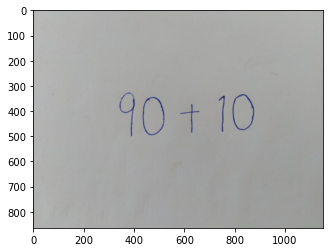

Phase 1 Completed --
Phase 2 Completed -- 

90+10  =  100


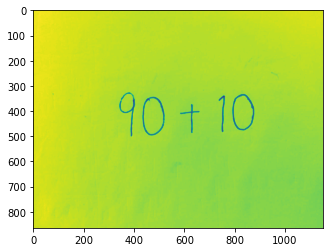

In [17]:
# path_to_image = '../input/math-equation-sol-2/test.jpg'
# path_to_image = '../input/math-equation-sol-2/1-4.jpeg'
# path_to_image = '../input/math-equation-sol-2/5-2.png'
# path_to_image = '../input/math-equation-sol-2/5x2.png'
# path_to_image = '../input/math-equation-sol-2/5x41.png'
path_to_image = '../input/math-equation-sol-2/sajal421x12.png'
model_predict(path_to_image)

Loading Model...
Loading weights...
Model 1 Loaded
Loading Model 2...
Loading weights 2...


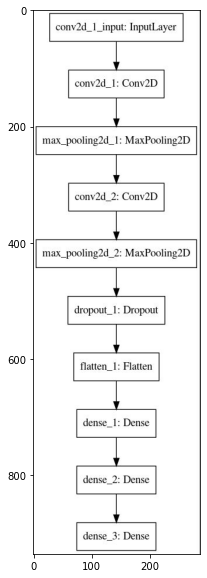

In [8]:
plt.figure(figsize = (10,10))
show_model(load_model()[0])

In [ ]:
model = Sequential()
model.add(Conv2D(30, 5, input_shape=(28, 28,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(13, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()